In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uszipcode import Zipcode, SearchEngine

In [2]:
pip install uszipcode

Note: you may need to restart the kernel to use updated packages.


In [3]:
covid = pd.read_csv('../data/california_covid.csv')
earthquake = pd.read_csv('../data/earthquakes_CA.csv')
fire = pd.read_csv('../data/fire_data.csv')

In [4]:
covid.head(2)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,6001.0,Alameda,California,US,2020-10-17 04:24:12,37.646294,-121.892927,22408,439,0,21969.0,"Alameda, California, US",1340.729443,1.959122
1,6003.0,Alpine,California,US,2020-10-17 04:24:12,38.596786,-119.822359,3,0,0,3.0,"Alpine, California, US",265.721878,0.000000


In [5]:
# bringing in county population data as a column to the covid dataframe
population = pd.read_html('https://www.california-demographics.com/counties_by_population')[0]

In [6]:
population.head(2)

,Rank,County,Population
0,1,Los Angeles County,10039107
1,2,San Diego County,3338330


In [7]:
earthquake.head(2)

,Event ID,Name/Epicenter,Date,Lat,Lon,Mag
0,73472891,"10 km (6.25 mi) ESE of Willits, CA",2020-10-19,39.36,-123.25,3.4
1,73472896,"11 km (6.875 mi) ESE of Willits, CA",2020-10-19,39.37,-123.24,3.8


In [8]:
fire.head(2)

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location
0,Apple Fire,False,2020-07-31T18:08:39Z,Riverside,0,0,-116.9617,33.99139,Wildfire,True,False,"off of Oak Glen Road and Apple Tree Lane, Nort..."
1,August Complex (includes Doe Fire),False,2020-08-16T20:37:26Z,"Mendocino, Humboldt, Trinity, Tehama, Glenn, L...",1032209,80,-122.6730,39.77600,Wildfire,True,True,"Mendocino, Humboldt, Trinity, Tehama, Glenn, ..."


In [9]:
covid.shape

(58, 14)

In [10]:
population.shape

(59, 3)

In [11]:
population = population[population['County'].str.contains('County')]

In [12]:
# fix county names so they don't contain 'County'
population['county'] = population['County'].apply(lambda x: ' '.join(x.split()[:-1]))

In [13]:
# drop 'Rank' and 'County' columns from population dataframe
population.drop(columns=['Rank', 'County'], inplace=True)

In [14]:
earthquake.shape

(200, 6)

In [15]:
fire.shape

(202, 12)

In [16]:
fire['Type'].value_counts()


Wildfire    202
Name: Type, dtype: int64

In [17]:
# drop `Type` column because they are all wildfires
fire.drop(columns = ['Type'], inplace = True)


The goal here is to merge dataframes based on county column as a common key. Covid data is clean and ready to go. Some fires extend to multiple counties. We are going to base our analysis on the county level, so we need to preserve the fire information for each county. Here, we are going to separate the county to individual counties while copying the fire data where the fire spans to multiple counties.

In [18]:
# first change the `County` column from str to a list
fire['County'] = fire['County'].apply(lambda x: x.split(', '))

In [19]:

# modified from https://stackoverflow.com/questions/24029659/python-pandas-replicate-rows-in-dataframe
# making copies of the rows with more than one county listed. The number of copies correspond to the number of counties
reps = [len(county) if  len(county) > 1 else 1 for county in fire['County']]
fire = fire.loc[np.repeat(fire.index.values, reps)]

In [20]:
# reset index 
fire.reset_index(inplace=True, drop=True)

In [21]:
# reassign single counties to the `County` column

# index counter and an empty counties list
index = 0
counties = []

# loop to have an index track to not go out of index range
for indexer in range(len(fire)):
    while index <= indexer:
        
        # if there is only a single county name, append that county name to the list
        if len(fire.iloc[index, 3]) == 1:
            counties.append(fire.iloc[index, 3][0])
            index += 1
            
        # if there is more than one single county name, append each county name to the list
        else:
            for i in range(0, len(fire.iloc[index, 3])):
                # append each indiviual county name of the multi-county list
                counties.append(fire.iloc[index, 3][i])
            # set the index, so that it goes to the next 'unique' item
            index += len(fire.iloc[index, 3])

# reassign `County` column to this new list
fire['County'] = counties


The earthquake dataset does not include county names, so we are making a new column with the county names assigned from latitude and longitude using the python uszipcode library.

In [22]:
# make a function to retrive the county name from lat and long 
def county_name(x):
    '''Takes in latitude and longitude (as a literable) and returns the closest county name for the given coordinates'''
    lat, long = x
    search = SearchEngine()
    result = search.by_coordinates(lat, long, radius=100)
    # get the county name
    try:
        county = result[0].county
        
        # this is in 'XXXX County', so fix the format so that it's only the county name without 'County' at the end
        county = county.split()
        
        # get everything but the last item (which is 'County')
        county = county[:-1]
        
        # return a string
        return ' '.join(county)
        
    except:
        print(f'Something went wrong. Check your coordinates: {x}')

In [23]:
counties = earthquake[['Lat', 'Lon']].apply(county_name, axis=1)

In [24]:

# add a county column
earthquake['county'] = counties

In [25]:
# making dictionaries to change column names before merging

covid_cols = {
    'FIPS': 'fips',
    'Admin2': 'county',
    'Province_State': 'province_state',
    'Country_Region': 'country',
    'Last_Update': 'covid_last_update',
    'Lat': 'covid_latitude',
    'Long_': 'covid_longitudue',
    'Confirmed': 'covid_confirmed',
    'Deaths': 'covid_death',
    'Recovered': 'covid_recoverd',
    'Active': 'covid_active',
    'Combined_Key': 'combined_key',
    'Incidence_Rate': 'covid_indidence_rate',
    'Case-Fatality_Ratio': 'covid_case_fatality_ratio',
    'Population': 'county_population'
}

earthquake_cols = {
    'Event ID': 'earthquake_id',
    'Name/Epicenter': 'eipicenter',
    'Date': 'earthquake_date',
    'Lat': 'earthquake_latidute',
    'Lon': 'earthquake_longitude',
    'Mag': 'magnitude'
}

fire_cols = {
    'Name': 'fire_name',
    'Final': 'fire_is_final',
    'Started': 'fire_started',
    'County': 'county',
    'AcresBurned': 'acres_burned',
    'PercentContained': 'fire_percent_contained',
    'Longitude': 'fire_longitude',
    'Latitude': 'fire_latitude',
    'IsActive': 'fire_is_active',
    'CalFireIncident': 'is_calfireincident',
    'Location': 'fire_location'
}

In [26]:
covid.rename(columns=covid_cols, inplace=True)

In [27]:
earthquake.rename(columns=earthquake_cols, inplace=True)

In [28]:
fire.rename(columns=fire_cols, inplace=True)

Merge all three dataframes using county as the common key. In order to keep all information, we are using outer merge.

In [29]:

# first merge the population data to covid data. this will be done as left join
covid = pd.merge(covid, population, on='county', how='left')

In [30]:
covid_earthquake = pd.merge(covid, earthquake, how='outer', on='county')

In [31]:
all_3 = pd.merge(covid_earthquake, fire, how='outer', on='county')

In [32]:
all_3.to_csv('../data/covid_fire_earthquake.csv')

In [33]:
df= pd.read_csv('../data/covid_fire_earthquake.csv')

In [34]:
pd.set_option('display.max_columns', None)

In [35]:
df.head(2)

,Unnamed: 0,fips,county,province_state,country,covid_last_update,covid_latitude,covid_longitudue,covid_confirmed,covid_death,covid_recoverd,covid_active,combined_key,covid_indidence_rate,covid_case_fatality_ratio,Population,earthquake_id,eipicenter,earthquake_date,earthquake_latidute,earthquake_longitude,magnitude,fire_name,fire_is_final,fire_started,acres_burned,fire_percent_contained,fire_longitude,fire_latitude,fire_is_active,is_calfireincident,fire_location
0,0,6001.0,Alameda,California,US,2020-10-17 04:24:12,37.646294,-121.892927,22408.0,439.0,0.0,21969.0,"Alameda, California, US",1340.729443,1.959122,1671329.0,NaN,NaN,NaN,NaN,NaN,NaN,Sheridan Fire,True,2020-07-04T15:04:41Z,108.0,100.0,-121.876277,37.536015,False,True,"Sheridan Road, south of Sunol in Santa Clara c..."
1,1,6001.0,Alameda,California,US,2020-10-17 04:24:12,37.646294,-121.892927,22408.0,439.0,0.0,21969.0,"Alameda, California, US",1340.729443,1.959122,1671329.0,NaN,NaN,NaN,NaN,NaN,NaN,Hollow Fire,True,2020-07-16T18:14:18Z,253.0,100.0,-121.593740,37.640440,False,True,"Tesla Road and McLaughlin Road, Southeast of L..."


In [36]:
df.columns

Index(['Unnamed: 0', 'fips', 'county', 'province_state', 'country',
       'covid_last_update', 'covid_latitude', 'covid_longitudue',
       'covid_confirmed', 'covid_death', 'covid_recoverd', 'covid_active',
       'combined_key', 'covid_indidence_rate', 'covid_case_fatality_ratio',
       'Population', 'earthquake_id', 'eipicenter', 'earthquake_date',
       'earthquake_latidute', 'earthquake_longitude', 'magnitude', 'fire_name',
       'fire_is_final', 'fire_started', 'acres_burned',
       'fire_percent_contained', 'fire_longitude', 'fire_latitude',
       'fire_is_active', 'is_calfireincident', 'fire_location'],
      dtype='object')

In [37]:
df.isnull().sum()

Unnamed: 0                     0
fips                           3
county                         0
province_state                 3
country                        3
covid_last_update              3
covid_latitude                 3
covid_longitudue               3
covid_confirmed                3
covid_death                    3
covid_recoverd                 3
covid_active                   3
combined_key                   3
covid_indidence_rate           3
covid_case_fatality_ratio      3
Population                     3
earthquake_id                142
eipicenter                   142
earthquake_date              142
earthquake_latidute          142
earthquake_longitude         142
magnitude                    142
fire_name                     36
fire_is_final                 36
fire_started                  36
acres_burned                  36
fire_percent_contained        36
fire_longitude                36
fire_latitude                 36
fire_is_active                36
is_calfire

In [38]:
# get number of acutal covid death by country 
#make a copy of our df
df_eda=df

In [39]:
import seaborn as sns

<ipython-input-40-a3cdc07839a2>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  covid_eda= df_eda.groupby(['county'])['covid_death', 'covid_recoverd', 'covid_active'].sum().reset_index()


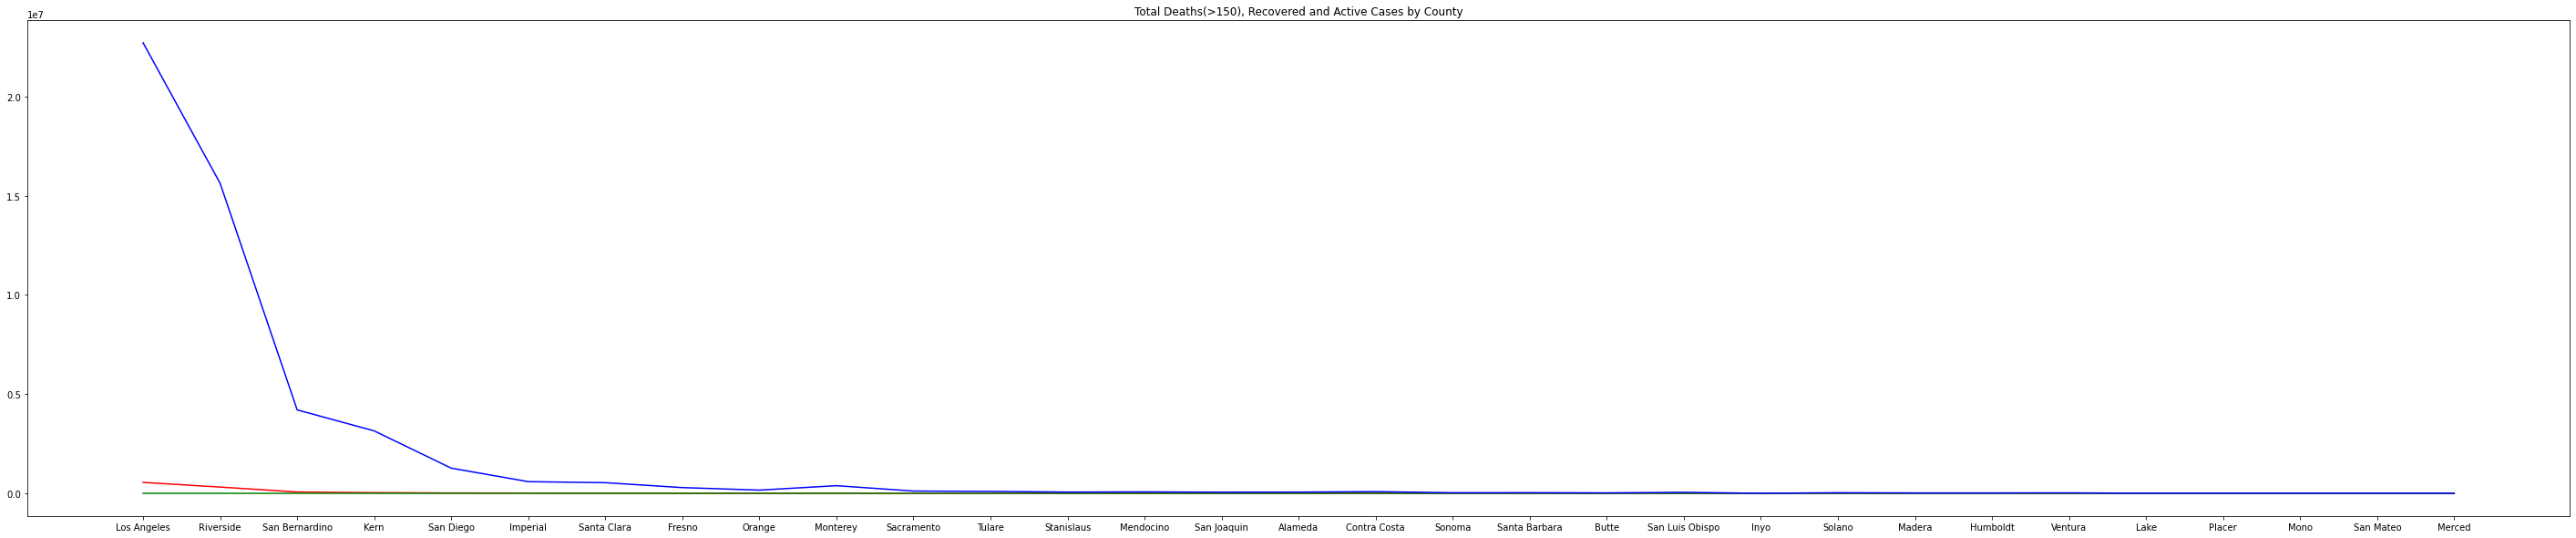

In [40]:
covid_eda= df_eda.groupby(['county'])['covid_death', 'covid_recoverd', 'covid_active'].sum().reset_index()
covid_eda= covid_eda.sort_values(by='covid_death', ascending=False)
covid_eda= covid_eda[covid_eda['covid_death']>150]
 
plt.figure(figsize=(50, 10))
plt.plot(covid_eda['county'], covid_eda['covid_death'],color='red')
plt.plot(covid_eda['county'], covid_eda['covid_recoverd'],color='green')
plt.plot(covid_eda['county'], covid_eda['covid_active'], color='blue')

 
plt.title('Total Deaths(>150), Recovered and Active Cases by County')
plt.show()

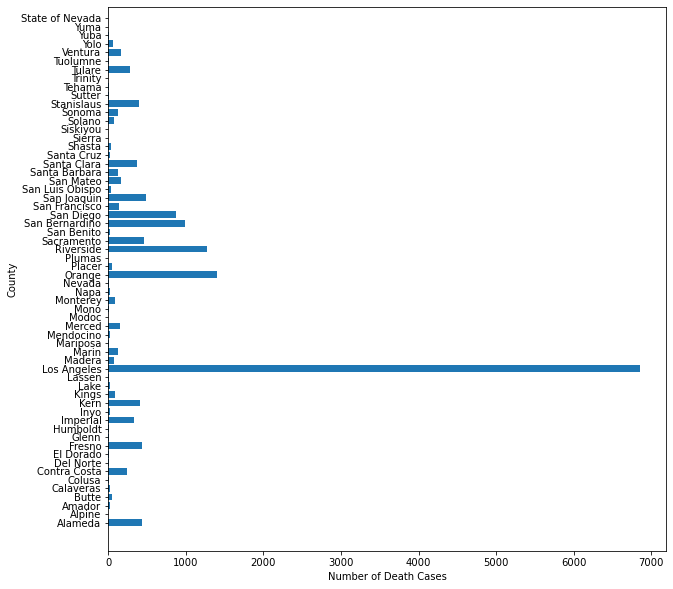

In [41]:
#plotting the initial horaizontal barchart 
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(df_eda['county'], df_eda['covid_death'])
plt.xlabel('Number of Death Cases')
plt.ylabel('County');

In [ ]:
df_covid=df_eda()

In [ ]:
sns.heatmap(df_eda.corr()[['county']])